<a href="https://colab.research.google.com/github/K-Kyungho/AIKU_DeepIntoDeep/blob/main/AIKUTHON_WANDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Libraies

In [2]:
import random
import numpy as np

!pip install pydicom
import pydicom

import os

import torchvision
from torchvision import transforms, datasets, models
import torchvision.transforms.functional as TF

import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

from PIL import Image


from tqdm.auto import tqdm

import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Configuration

In [4]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Data preprocessing

## Set data directories

In [5]:
IMAGE_DIR = '/content/drive/MyDrive/AIKUTHON/data/train/imgs'
MASK_DIR = '/content/drive/MyDrive/AIKUTHON/data/train/masks'
TEST_DIR = '/content/drive/MyDrive/AIKUTHON/data/test/imgs'

## Dataset

In [6]:
input_dim = (600, 800)

num_classes = 13

In [7]:
def get_image(img_path):
    '''
    (3, H, W)의 이미지를 열고,  Normalized된 (3, INPUT_H, INPUT_W)의 Tensor로 바꾸어주는 함수
    '''
    img = Image.open(img_path)
    
    pil_to_tensor = transforms.ToTensor()
    img = pil_to_tensor(img)
    
    normalize = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    img = normalize(img)
    
    return img

def get_mask(mask_path):
    '''
    (3, H, W)의 이미지를 열고, (3, INPUT_H, INPUT_W)의 Tensor로 바꾸어주는 함수
    '''
    mask = Image.open(mask_path)
    
    pil_to_tensor = transforms.ToTensor()
    mask = pil_to_tensor(mask) * 255
    
    return mask

def one_hot_encoding(mask):
    '''
    (3, INPUT_H, INPUT_W)의 이미지를 열고, (NUM_CLASSES, INPUT_H, INPUT_W)의 Tensor로 바꾸어주는 함수
    '''
    mask = torch.stack([mask==i for i in range(num_classes)], dim=1).int()

    return mask[0]

In [8]:
class TrainDataset(Dataset):
    def __init__(self, img_dir, mask_dir):      
        self.img_dir = img_dir
        self.img_path = list(sorted([os.path.join(img_dir, img_name) for img_name in os.listdir(img_dir)]))

        self.mask_dir = mask_dir
        self.mask_path = list(sorted([os.path.join(mask_dir, mask_name) for mask_name in os.listdir(mask_dir)]))
        
    def train_transform(self, img, mask):
        # Random Scaling & Cropping
        scaler = random.randrange(1, 2)
        img = torch.nn.functional.interpolate(img, scale_factor=scaler)
        mask = torch.nn.functional.interpolate(mask, scale_factor=scaler)
        
        params = transforms.RandomCrop.get_params(img, output_size=input_dim)
        img = TF.crop(img, *params)
        mask = TF.crop(mask, *params)

        # Random Horizontal Flipping
        if random.random() > 0.5:
            img = TF.hflip(img)
            mask = TF.hflip(mask)
            
        mask = one_hot_encoding(mask)
        return img, mask
    
    def __len__(self):
        return len(self.img_path)
    
    def __getitem__(self, idx):
        img = get_image(self.img_path[idx])
        mask = get_mask(self.mask_path[idx])
        
        img, mask = self.train_transform(img, mask)
        return img, mask

        
class TestDataset(Dataset):
    def __init__(self, img_dir):
        self.img_dir = img_dir    
        self.img_path = [os.path.join(img_dir, img_name) for img_name in os.listdir(img_dir)]
        
    def __len__(self):
        return len(self.img_path)
    
    def __getitem__(self, idx):
        img_name = os.listdir(self.img_dir)[idx].split('.')[0]
        img = get_image(self.img_path[idx]) 
        return img_name, img

In [9]:
original_dataset = TrainDataset(IMAGE_DIR, MASK_DIR)

In [10]:
# TRAIN / DEV DATASET 비율 설정
train_rate = 0.8
dev_rate = 0.2

In [11]:
# Function that split data by pre-defined proportions
def data_split(orig_dataset, train_rate, dev_rate):
    if train_rate + dev_rate != 1:
        raise ValueError
    
    orig_size = len(orig_dataset)
    
    dev_size = int(orig_size * dev_rate)
    train_size = int(orig_size - dev_size)
    
    train_dataset, dev_dataset= random_split(orig_dataset, [train_size, dev_size])
    
    return train_dataset, dev_dataset

In [12]:
train_dataset, dev_dataset = data_split(original_dataset, train_rate, dev_rate)

## Check

# NUMBER OF TRAIN DATA: 3080
# NUMBER OF DEV   DATA: 770
# IMG SHAPE: torch.Size([3, 600, 800]) | MASK SHAPE: torch.Size([13, 600, 800])
# IMAGE / MASK PREVIEW:


Text(0.5, 1.0, 'Mask')

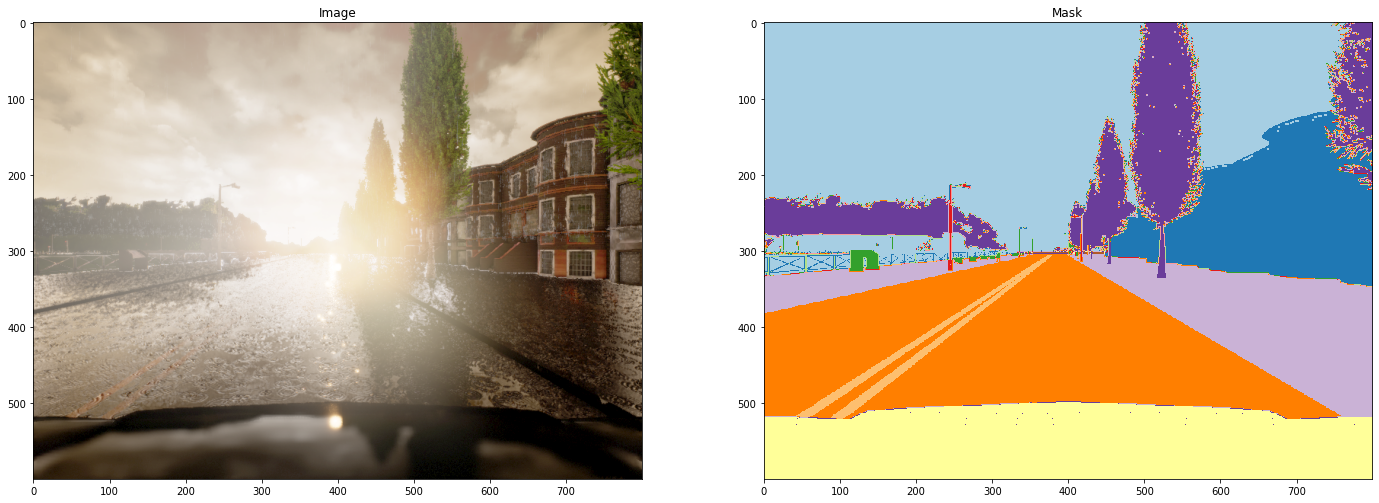

In [13]:
num_train_data, num_dev_data = len(train_dataset), len(dev_dataset)
print(f'# NUMBER OF TRAIN DATA: {num_train_data}')
print(f'# NUMBER OF DEV   DATA: {num_dev_data}')

img, mask = train_dataset[10]
print(f'# IMG SHAPE: {img.shape} | MASK SHAPE: {mask.shape}')
print('# IMAGE / MASK PREVIEW:')

unnormalize = transforms.Compose([
        transforms.Normalize((0, 0, 0), (1/0.229, 1/0.224, 1/0.225)),
        transforms.Normalize((-0.485, -0.456, -0.406), (1, 1, 1))
    ])

img = unnormalize(img)
img = transforms.functional.to_pil_image(img)

mask = torch.squeeze(mask.argmax(dim=0), 0)
    
fig, arr = plt.subplots(1, 2, figsize=(24, 12))

arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask, cmap='Paired')
arr[1].set_title('Mask')

## Dataloader

## DataLoader

In [14]:
# Set batch size
batch_size = 2

# Get DATALOADER
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, batch_size, shuffle=False)

# Model

In [16]:
# MODEL
class CustomModel(nn.Module):
    def __init__(self, output_channels):
        super(CustomModel, self).__init__()

        self.model = models.segmentation.deeplabv3_resnet101(weights='DEFAULT')
        self.model.classifier = models.segmentation.deeplabv3.DeepLabHead(2048, output_channels)
        self.model.aux_classifier = models.segmentation.deeplabv3.FCNHead(1024, output_channels)

        for name, parameter in self.model.named_parameters():
            tmp = name.split('.')
            if('classifier' in tmp) or ('aux_classifier' in tmp):
                parameter.requires_grad = True
            else:
                parameter.requires_grad = False

    def forward(self, x):
        return self.model(x)

In [17]:
def get_model(num_classes):
    model = CustomModel(num_classes)
    return model

In [18]:
def get_optimizer(model, learning_rate, weight_decay=0):
    optimizer = optim.Adam(model.parameters(),
                           lr=learning_rate,
                           weight_decay=0)
    return optimizer

# Train

In [20]:
MODEL_DIR = '/content/drive/MyDrive/AIKUTHON/model'

In [35]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, pred, targets, smooth=1):
        pred = torch.sigmoid(pred['out'])
        smooth = 1e-5
        
        pred = pred.view(-1)
        targets = targets.view(-1)
        
        intersect = torch.sum(pred * targets)
        y_sum = torch.sum(targets * targets)
        z_sum = torch.sum(pred * pred)
        loss = (2 * intersect + smooth) / (z_sum + y_sum + smooth)
        
        return 1 - loss

In [36]:
# Function for LambdaLR # 나중에 수정해야함.
def decay_func(epoch):
    if epoch < 20:
        return 0.5 ** 0
    elif epoch < 25:
        return 0.5 ** 1
    elif epoch < 30:
        return 0.5 ** 2
    else:
        return 0.5 ** 4

In [37]:
def train(model, criterion, optimizer, dataloader):
    model.train()

    losses = 0
    for images, masks in tqdm(dataloader):
        images, masks  = images.to(device), masks.to(device)

        output = model(images)
        loss = criterion(output, masks)
        losses += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    losses = losses / len(dataloader)
    return losses

In [38]:
def evaluate(model, criterion, optimizer, dataloader):
    model.eval()

    losses = 0
    with torch.no_grad():
        for images, masks in tqdm(dataloader):
            images, masks = images.to(device), masks.to(device)

            output = model(images)
            loss = criterion(output, masks)
            losses += loss.item()

    losses = losses / len(dataloader)
    return losses

In [45]:
epochs = 5

Error in callback <function _WandbInit._resume_backend at 0x7f4bd840fca0> (for pre_run_cell):


BrokenPipeError: ignored

Error in callback <function _WandbInit._pause_backend at 0x7f4bd840fb80> (for post_run_cell):


BrokenPipeError: ignored

In [40]:
def fit():    
    run = wandb.init()
    w_config = run.config

    # Model
    model = get_model(num_classes).to(device)

    # Loss Function
    criterion = DiceLoss()

    # Optimizer 
    optimizer = get_optimizer(model, w_config.learning_rate, w_config.weight_decay)
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = decay_func)
    
    wandb.watch(model, criterion, log="all", log_freq=10)
    
    for epoch in range(epochs):
        # Train
        train_loss = train(model, criterion, optimizer, train_dataloader)
        print(f"# TRAIN     (EPOCH: {epoch + 1}/{epochs}) | LOSS: {train_loss:.4f} | DICE SCORE: {(1-train_loss):.4f} ")

        # Dev
        dev_loss = evaluate(model, criterion, optimizer, dev_dataloader)
        print(f"# DEV (EPOCH: {epoch + 1}/{epochs}) | LOSS: {dev_loss:.4f} | DICE SCORE: {(1-dev_loss):.4f} ")
        # Leaning Rate Decay를 위한 Scheduler 갱신
        
        wandb.log({
            "train_loss": train_loss,
            "dev_loss": dev_loss,
        })
        
        scheduler.step()
        
    print(f"# SUMMARY")
    print(f"# FINAL TRAIN | LOSS: {train_loss:.4f} | DICE SCORE: {(1-train_loss) :.4f} ")
    print(f"# FINAL DEV   | LOSS: {dev_loss:.4f} | DICE SCORE: {(1-dev_loss) :.4f} ")
    
    # 모델 저장
#     torch.save(model.state_dict(), os.path.join(MODEL_DIR, 'final_model.pth'))
    
    return train_losses, dev_losses

In [41]:
# WandB Configuration
!pip install wandb
!wandb login 6c9bd21d7e57e5ccd5f99707c39402dd8a3bfe82
import wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [44]:
# Sweep에 필요한 값 설정
sweep_config = {
    'method': 'random',
    'name': 'first_try',
    'metric': {'goal': 'minimize', 'name': 'train_loss'}, # grid, bayes
    'parameters': 
    {
        'weight_decay': {
            'values': [0.1, 0.001, 0.0001, 0.00001]
        },
        'learning_rate': {
            'values': [0.002, 0.001, 0.001]
        }
     }
}

# Sweep에 필요한 sweep_id생성
sweep_id = wandb.sweep(sweep_config)

# Model Test
wandb.agent(sweep_id, fit, count = 3) # Sweep_id정보를 바탕으로 train함수를 이용해서 Trial을 10번 수행하겠다는 코드.

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: 12zfryc0
Sweep URL: https://wandb.ai/aiku/uncategorized/sweeps/12zfryc0


wandb: Agent Starting Run: vhvf0pqv with config:
wandb: 	epochs: 5
wandb: 	learning_rate: 4.531056266444744e-05
wandb: 	weight_decay: 1e-05
Exception in thread Thread-24:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "<ipython-input-40-3e2bb9743b9d>", line 19, in fit
  File "<ipython-input-37-32a5e47e99a1>", line 8, in train
  File "/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py", line 1215, in _call_impl
    hook_result = hook(self, input, result)
  File "/usr/local/lib/python3.8/dist-packages/wandb/wandb_torch.py", line 110, in <lambda>
    lambda mod, inp, outp: parameter_log_hook(
  File "/usr/local/lib/python3.8/dist-packages/wandb/wandb_torch.py", line 105, in parameter_log_hook
    self.log_tensor_stats(data.cpu(), "parameters/" + prefix + name)
  File "/usr/local/lib/python3.8/dist-packages/wandb/wandb_torch.py", line 256, in log_tensor_stats
    wa

  0%|          | 0/1540 [00:00<?, ?it/s]

wandb: Ctrl + C detected. Stopping sweep.


Error in callback <function _WandbInit._pause_backend at 0x7f4bd840fb80> (for post_run_cell):


BrokenPipeError: ignored

In [ ]:
def get_test_mask(img, model):
    img = torch.unsqueeze(img, 0)
    
    pred = model(img)
    pred = pred['out']
    pred = torch.squeeze(pred, 0)
    mask = torch.squeeze(pred.argmax(dim=0), 0)
    
    return mask

def visualize(img, mask, test_mask):
    unnormalize = transforms.Compose([
        transforms.Normalize((0, 0, 0), (1/0.229, 1/0.224, 1/0.225)),
        transforms.Normalize((-0.485, -0.456, -0.406), (1, 1, 1))
    ])
    
    fig, arr = plt.subplots(1, 3, figsize=(24, 12))

    arr[0].imshow(transforms.functional.to_pil_image(unnormalize(img)))
    arr[0].set_title('Image')
    arr[1].imshow(mask.cpu(), cmap='Paired')
    arr[1].set_title('Mask')
    arr[2].imshow(test_mask.cpu(), cmap='Paired')
    arr[2].set_title('Test Mask')

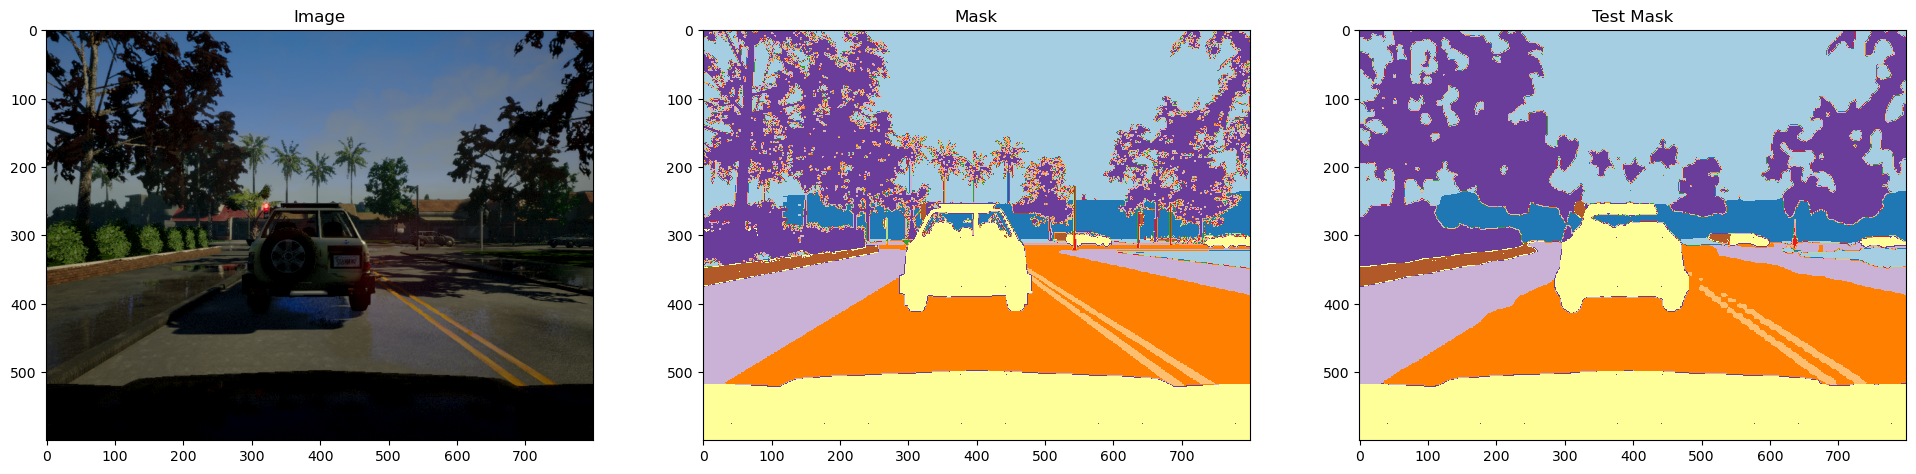

In [ ]:
test_model = CustomModel(num_classes).to(device)
test_model.load_state_dict(torch.load(os.path.join(MODEL_DIR, 'final_model.pth')))

test_model.eval()

imgs = [os.path.join(IMAGE_DIR, file_name) for file_name in os.listdir(IMAGE_DIR)]
masks = [os.path.join(MASK_DIR, file_name) for file_name in os.listdir(MASK_DIR)]

with torch.no_grad():
    for img, mask in dev_dataset:
        img = img.to(device)
        mask = mask.to(device)

        mask =torch.squeeze(mask.argmax(dim=0), 0)

        test_mask = get_test_mask(img, test_model).to(device)

        visualize(img, mask, test_mask)
        break

# Compute Metric : DICE

In [ ]:
def rle_encode(mask_image):
    pixels = mask_image.flatten()
    # We avoid issues with '1' at the start or end (at the corners of
    # the original image) by setting those pixels to '0' explicitly.
    # We do not expect these to be non-zero for an accurate mask,
    # so this should not harm the score.
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]
    return runs

In [ ]:
### 제출 방법입니다. 대표적으로 train한 모델의 weight를 저장한 후에 test할시, 모델의 weight를 불러와서 test image를 inference 해줍니다.
test_model = CustomModel(num_classes).to(device)
test_model.load_state_dict(torch.load(os.path.join(MODEL_DIR, 'final_model.pth')))

###batch_size=1, shuffle=False로 해야합니다. 그래야 sample_submission에 나와있는 img_id순서와 동일하게 순서가 일치하게 됩니다.
test_dataset = TestDataset(TEST_DIR)
test_dataloader = DataLoader(test_dataset, batch_size = 1, shuffle = False)

output = []

test_model.eval()
with torch.no_grad():
    for img_name, img in tqdm(test_dataloader):
        img = img.to(device)
        prediction = test_model(img)
        prediction = prediction['out'].argmax(dim=1)

        mask_labels = []

        ##제출코드 및 RLE encoding을 해주는 방법입니다.
        ##img_name[0]에는 images파일의 이름이 들어가야합니다.
        ##만약 test_1001.png파일을 불러왔다면 img_name[0]='test_1001'이 들어와야 합니다.
        for j in range(13):
            mask_label = torch.zeros(prediction.shape)
            mask_label[prediction==j]=1

            mask_labels.append(mask_label)
        for j in range(0,13):
            mask_label = mask_labels[j].squeeze().numpy()
            encode = rle_encode(mask_label)
            output.append((f'{img_name[0]}_{j}', ' '.join(str(_) for _ in encode)))

  0%|          | 0/1150 [00:00<?, ?it/s]

In [ ]:
import pandas as pdb

df = pdb.DataFrame(output)
df.columns=['ImageId','EncodedPixels']
df=df.set_index('ImageId')

# df.to_csv('/kaggle/working/result.csv')
df.to_csv('/content/drive/MyDrive/AIKUTHON/result.csv')